In [8]:
import numpy as np
import os
import glob
import matplotlib
import matplotlib.pyplot as plt
import plotly
import plotly.graph_objs as go
import scipy.linalg
import chart_studio.plotly as py
from mpl_toolkits.mplot3d import Axes3D

%matplotlib inline


In [9]:

D1 = {}


pdbfiles = glob.glob("*_aligned.pdb")
O1 = [ [],[],[] ]
N1 = [ [],[],[] ]
for pdbfile in pdbfiles:
    with open(pdbfile) as in_f: 
        for atom in in_f:
            atm_label = atom.split()[0]
            if atm_label == "CONECT" or atm_label == "END":
                pass
            else: 
                atid = atom.split()[1]
                atm_type = atom.split()[2]
                res_type = atom.split()[3]
                resid = atom.split()[5]    
                if atm_label == "ATOM":  
                    if atm_type == "N":
                        res_num = resid
                    if resid == res_num:
                        if atm_type == "N" or atm_type == "CA" or atm_type == "O" or atm_type == "C": 
                            ref = atm_type + resid
                            if pdbfiles.index(pdbfile) == 0:
                                D1[ref] = {"line_start": atom[0:26], "line_end": atom[55:], "x":[], "y":[], "z":[] } 
                            x = float(atom.split()[-6])
                            y = float(atom.split()[-5])
                            z = float(atom.split()[-4])                           
                            D1[ref]["x"].append(x)
                            D1[ref]["y"].append(y)
                            D1[ref]["z"].append(z)  
                elif atm_label == "HETATM":
                    x = float(atom.split()[-6]) 
                    y = float(atom.split()[-5])
                    z = float(atom.split()[-4]) 
                    if atm_type == "N":
                        N1[0].append(x)
                        N1[1].append(y)
                        N1[2].append(z)
                    elif atm_type == "O":
                        O1[0].append(x)
                        O1[1].append(y)
                        O1[2].append(z)
                        
                    

D2 = {}
for ref_atm in D1:
    D2[ref_atm] = {}
    D2[ref_atm]["line_start"] = D1[ref_atm]["line_start"]
    D2[ref_atm]["line_end"] = D1[ref_atm]["line_end"]
    D2[ref_atm]["x"] = np.average(D1[ref_atm]["x"])
    D2[ref_atm]["y"] = np.average(D1[ref_atm]["y"])
    D2[ref_atm]["z"] = np.average(D1[ref_atm]["z"])




In [10]:
with open("average.pdb", 'w') as out_pdb:
    for res in range (1, 124):
        for atom_name in ["N", "CA", "O", "C"]:
            entry = atom_name + str(res)
            out_pdb.write("%s % 11.3f % 7.3f % 7.3f%s" %(D2[entry]["line_start"],D2[entry]["x"],D2[entry]["y"],D2[entry]["z"],D2[entry]["line_end"]))
#            out_pdb.write(D2[entry]["line_start"]+"('% 8.3f' %D2[entry]["x"])"+"{:4.3f}".format(D2[entry]["y"])+"{:4.3f}".format(D2[entry]["z"])+D2[entry]["line_end"])

In [11]:
data = np.c_[O1[0],O1[1],O1[2]]
#print(data[:,0])
# regular grid covering the domain of the data
mn = np.min(data, axis=0)
mx = np.max(data, axis=0)
X,Y = np.meshgrid(np.linspace(mn[0], mx[0], 20), np.linspace(mn[1], mx[1], 20))
XX = X.flatten()
YY = Y.flatten()

# best-fit linear plane (1st-order)
A = np.c_[data[:,0], data[:,1], np.ones(data.shape[0])]
C,_,_,_ = scipy.linalg.lstsq(A, data[:,2])    # coefficients
    
# evaluate it on grid
Z = C[0]*X + C[1]*Y + C[2]

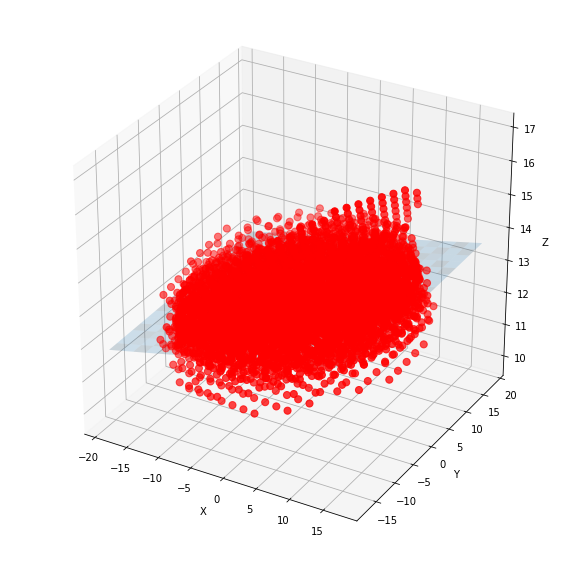

In [12]:
# plot points and fitted surface using Matplotlib
fig1 =  plt.figure(figsize=(10, 10))
ax = fig1.gca(projection='3d')
ax.plot_surface(X, Y, Z, rstride=1, cstride=1, alpha=0.2)
ax.scatter(data[:,0], data[:,1], data[:,2], c='r', s=50)
plt.xlabel('X')
plt.ylabel('Y')
ax.set_zlabel('Z')
ax.axis('equal')
ax.axis('tight')

# plot points and fitted surface using Plotly
trace1 = go.Scatter3d(
    x=data[:,0],
    y=data[:,1],
    z=data[:,2],
    mode='markers',
    marker=dict(size=4, color='red', line=dict(color='black', width=0.5), opacity=0.8)
)

trace2 = go.Surface(z=Z, x=X, y=Y, colorscale='RdBu', opacity=0.999)

# Package the trace dictionary into a data object
data_test1 = go.Data([trace1, trace2])

# Package the trace dictionary into a data object
data_test1 = go.Data([trace1, trace2])

# Dictionary of style options for all axes
axis = dict(
    showbackground=True, # show axis background
    backgroundcolor="rgb(204, 204, 204)", # set background color to grey
    gridcolor="rgb(255, 255, 255)",       # set grid line color
    zerolinecolor="rgb(255, 255, 255)",   # set zero grid line color
)

# Make a layout object
layout = go.Layout(
    title='1st-order (linear) plane', # set plot title
    scene=go.Scene(  # axes are part of a 'scene' in 3d plots
        xaxis=go.XAxis(axis), # set x-axis style
        yaxis=go.YAxis(axis), # set y-axis style
        zaxis=go.ZAxis(axis)),  # set z-axis style
)

# Make a figure object
fig = go.Figure(data=data_test1, layout=layout)

# Send to Plotly and show in notebook
py.iplot(fig, filename='test1')

In [13]:
dataN = np.c_[N1[0],N1[1],N1[2]]
#print(data[:,0])
# regular grid covering the domain of the data
mn = np.min(dataN, axis=0)
mx = np.max(dataN, axis=0)
XN,YN = np.meshgrid(np.linspace(mn[0], mx[0], 20), np.linspace(mn[1], mx[1], 20))
XXN = XN.flatten()
YYN = YN.flatten()

# best-fit linear plane (1st-order)
A = np.c_[dataN[:,0], dataN[:,1], np.ones(dataN.shape[0])]
CN,_,_,_ = scipy.linalg.lstsq(A, dataN[:,2])    # coefficients
    
# evaluate it on grid
ZN = CN[0]*XN + CN[1]*YN + CN[2]

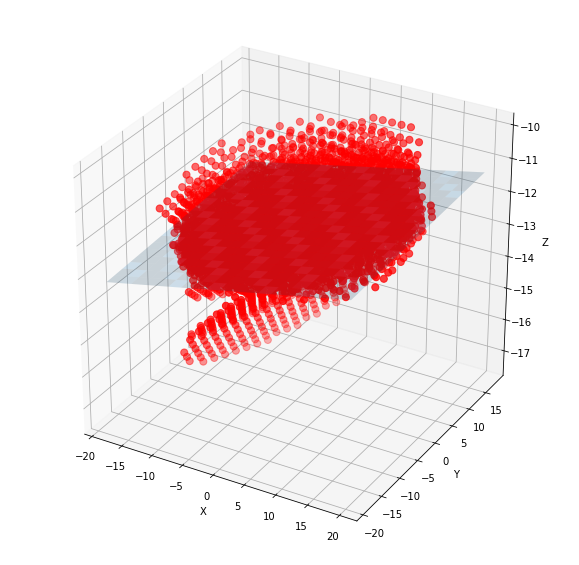

In [15]:
# plot points and fitted surface using Matplotlib
fig1 =  plt.figure(figsize=(10, 10))
ax = fig1.gca(projection='3d')
ax.plot_surface(XN, YN, ZN, rstride=1, cstride=1, alpha=0.2)
ax.scatter(dataN[:,0], dataN[:,1], dataN[:,2], c='r', s=50)
plt.xlabel('X')
plt.ylabel('Y')
ax.set_zlabel('Z')
ax.axis('equal')
ax.axis('tight')

# plot points and fitted surface using Plotly
trace1N = go.Scatter3d(
    x=dataN[:,0],
    y=dataN[:,1],
    z=dataN[:,2],
    mode='markers',
    marker=dict(size=4, color='red', line=dict(color='black', width=0.5), opacity=0.8)
)

trace2N = go.Surface(z=ZN, x=XN, y=YN, colorscale='RdBu', opacity=0.999)

# Package the trace dictionary into a data object
data_test1N = go.Data([trace1N, trace2N])

# Dictionary of style options for all axes
axis = dict(
    showbackground=True, # show axis background
    backgroundcolor="rgb(204, 204, 204)", # set background color to grey
    gridcolor="rgb(255, 255, 255)",       # set grid line color
    zerolinecolor="rgb(255, 255, 255)",   # set zero grid line color
)

# Make a layout object
layout = go.Layout(
    title='1st-order (linear) plane', # set plot title
    scene=go.Scene(  # axes are part of a 'scene' in 3d plots
        xaxis=go.XAxis(axis), # set x-axis style
        yaxis=go.YAxis(axis), # set y-axis style
        zaxis=go.ZAxis(axis)),  # set z-axis style
)

# Make a figure object
figN = go.Figure(data=data_test1N, layout=layout)

# Send to Plotly and show in notebook
py.iplot(figN, filename='test2')

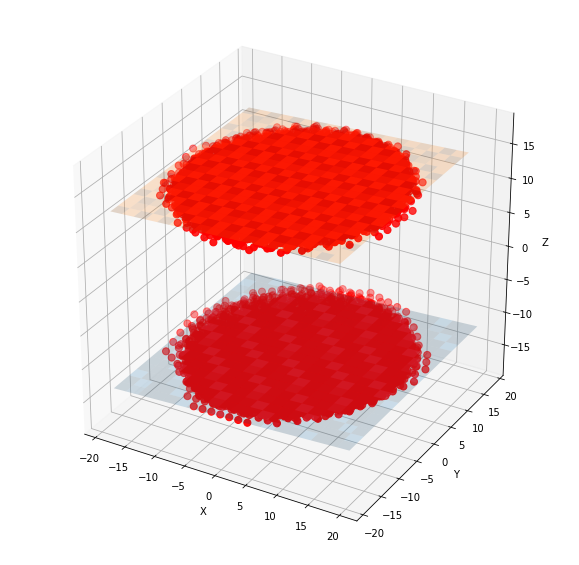

In [16]:
# plot points and fitted surface using Matplotlib
figB =  plt.figure(figsize=(10, 10))
ax = figB.gca(projection='3d')
ax.plot_surface(XN, YN, ZN, rstride=1, cstride=1, alpha=0.2)
ax.plot_surface(X, Y, Z, rstride=1, cstride=1, alpha=0.2)
ax.scatter(dataN[:,0], dataN[:,1], dataN[:,2], c='r', s=50)
ax.scatter(data[:,0], data[:,1], data[:,2], c='r', s=50)
plt.xlabel('X')
plt.ylabel('Y')
ax.set_zlabel('Z')
ax.axis('equal')
ax.axis('tight')

# plot points and fitted surface using Plotly
trace1 = go.Scatter3d(
    x=data[:,0],
    y=data[:,1],
    z=data[:,2],
    mode='markers',
    marker=dict(size=4, color='red', line=dict(color='black', width=0.5), opacity=0.8)
)
trace1N = go.Scatter3d(
    x=dataN[:,0],
    y=dataN[:,1],
    z=dataN[:,2],
    mode='markers',
    marker=dict(size=4, color='red', line=dict(color='black', width=0.5), opacity=0.8)
)

trace2N = go.Surface(z=ZN, x=XN, y=YN, colorscale='RdBu', opacity=0.999)
trace2 = go.Surface(z=Z, x=X, y=Y, colorscale='RdBu', opacity=0.999)

# Package the trace dictionary into a data object
data_testB = go.Data([trace1N, trace2N, trace1, trace2])

# Dictionary of style options for all axes
axis = dict(
    showbackground=True, # show axis background
    backgroundcolor="rgb(204, 204, 204)", # set background color to grey
    gridcolor="rgb(255, 255, 255)",       # set grid line color
    zerolinecolor="rgb(255, 255, 255)",   # set zero grid line color
)

# Make a layout object
layout = go.Layout(
    title='1st-order (linear) plane', # set plot title
    scene=go.Scene(  # axes are part of a 'scene' in 3d plots
        xaxis=go.XAxis(axis), # set x-axis style
        yaxis=go.YAxis(axis), # set y-axis style
        zaxis=go.ZAxis(axis)),  # set z-axis style
)

# Make a figure object
fig = go.Figure(data=data_testB, layout=layout)

# Send to Plotly and show in notebook
py.iplot(fig, filename='test2')

In [17]:
print(X,Y,Z,XN,YN,ZN)

(array([[-19.006     , -17.09578947, -15.18557895, -13.27536842,
        -11.36515789,  -9.45494737,  -7.54473684,  -5.63452632,
         -3.72431579,  -1.81410526,   0.09610526,   2.00631579,
          3.91652632,   5.82673684,   7.73694737,   9.64715789,
         11.55736842,  13.46757895,  15.37778947,  17.288     ],
       [-19.006     , -17.09578947, -15.18557895, -13.27536842,
        -11.36515789,  -9.45494737,  -7.54473684,  -5.63452632,
         -3.72431579,  -1.81410526,   0.09610526,   2.00631579,
          3.91652632,   5.82673684,   7.73694737,   9.64715789,
         11.55736842,  13.46757895,  15.37778947,  17.288     ],
       [-19.006     , -17.09578947, -15.18557895, -13.27536842,
        -11.36515789,  -9.45494737,  -7.54473684,  -5.63452632,
         -3.72431579,  -1.81410526,   0.09610526,   2.00631579,
          3.91652632,   5.82673684,   7.73694737,   9.64715789,
         11.55736842,  13.46757895,  15.37778947,  17.288     ],
       [-19.006     , -17.09578947, 

In [18]:
print(C,CN)

(array([  4.39881099e-02,   4.46450896e-03,   1.27917455e+01]), array([  4.03289638e-02,   8.69933496e-03,  -1.22750548e+01]))


In [19]:
coord1 = [-20.0,0.0]
coord2 = [0.0,20.0]
coord3 = [20.0,0.0]
coord4 = [0.0,-20.0]

In [20]:
ZO1 = C[0]*coord1[0] + C[1]*coord1[1] + C[2]
ZO2 = C[0]*coord2[0] + C[1]*coord2[1] + C[2]
ZO3 = C[0]*coord3[0] + C[1]*coord3[1] + C[2]
ZO4 = C[0]*coord4[0] + C[1]*coord4[1] + C[2]

ZN1 = CN[0]*coord1[0] + CN[1]*coord1[1] + CN[2]
ZN2 = CN[0]*coord2[0] + CN[1]*coord2[1] + CN[2]
ZN3 = CN[0]*coord3[0] + CN[1]*coord3[1] + CN[2]
ZN4 = CN[0]*coord4[0] + CN[1]*coord4[1] + CN[2]

points = {"O1": [coord1[0],coord1[1],ZO1] ,"O2": [coord2[0],coord2[1],ZO2] ,"O3": [coord3[0],coord3[1],ZO3] , "O4": [coord4[0],coord4[1],ZO4] ,"N1": [coord1[0],coord1[1],ZN1] ,"N2": [coord2[0],coord2[1],ZN2] ,"N3": [coord3[0],coord3[1],ZN3] , "N4": [coord4[0],coord4[1],ZN4]}


In [22]:
N_atm = 1393
N_res = 123

with open("average.pdb", 'w') as out_pdb:
    for res in range (1, 124):
        for atom_name in ["N", "CA", "O", "C"]:
            entry = atom_name + str(res)
            out_pdb.write("%s % 11.3f % 7.3f % 7.3f%s" %(D2[entry]["line_start"],D2[entry]["x"],D2[entry]["y"],D2[entry]["z"],D2[entry]["line_end"]))
#            out_pdb.write(D2[entry]["line_start"]+"('% 8.3f' %D2[entry]["x"])"+"{:4.3f}".format(D2[entry]["y"])+"{:4.3f}".format(D2[entry]["z"])+D2[entry]["line_end"])
    for hetatm in range (1,5):
        N_res += 1
        for atom_name in ["N","O"]:
            N_atm += 1
            entry = atom_name + str(hetatm)
            out_pdb.write("HETATM %4d  %s   DUM  %4d % 11.3f % 7.3f % 7.3f  0.00  0.00           %s\n" %(N_atm,atom_name,N_res,points[entry][0],points[entry][1],points[entry][2],atom_name) )
            
            
#HETATM    5  N   DUM  2551     -16.239   0.161 -12.698  0.00  0.00           N  
#HETATM    6  O   DUM  2551     -16.163   0.232  12.102  0.00  0.00           O 
#ATOM   1393  C   GLY A 126      -7.186  -7.992 -15.359 1.00  0.00           C 